In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Set the directory paths for the classes
classes = ['High squamous intra-epithelial lesion', 
           'Low squamous intra-epithelial lesion', 
           'Negative for Intraepithelial malignancy', 
           'Squamous cell carcinoma']

# Initialize the image list and class labels
image_paths = []
labels = []

# Loop through the directories and collect images
for label, class_name in enumerate(classes):
    class_dir = f'data/{class_name}'  # Correct path based on your structure
    for img_file in os.listdir(class_dir):
        if img_file.endswith(".jpg"):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_name)

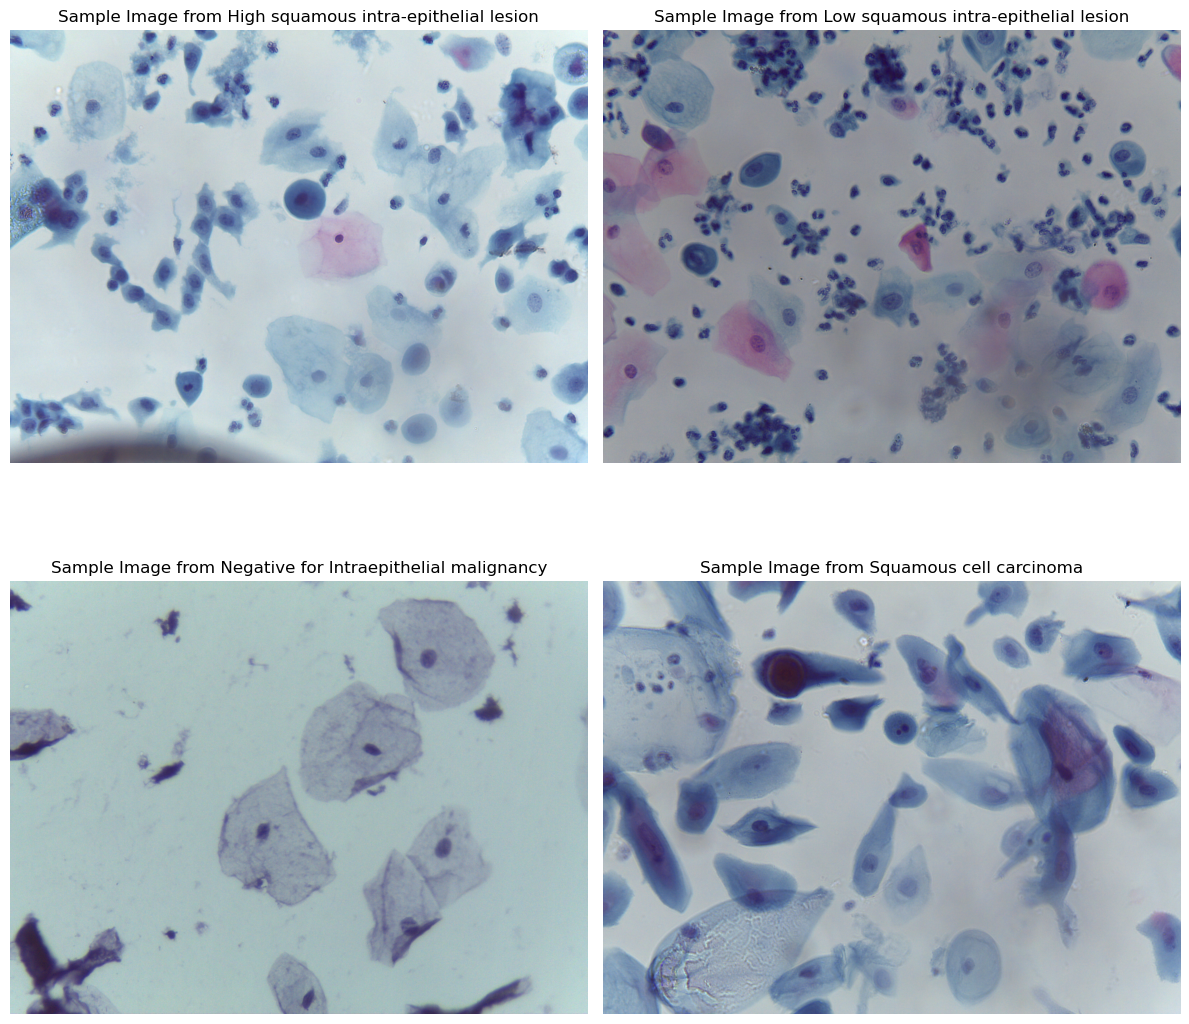

In [3]:
import random
# Show a few sample images from each class
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, (class_name, ax) in enumerate(zip(classes, axes)):
    # Find one image from each class
    class_images = [img for img, label in zip(image_paths, labels) if label == class_name]
    img_path = class_images[random.randint(0,112)] 
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Sample Image from {class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

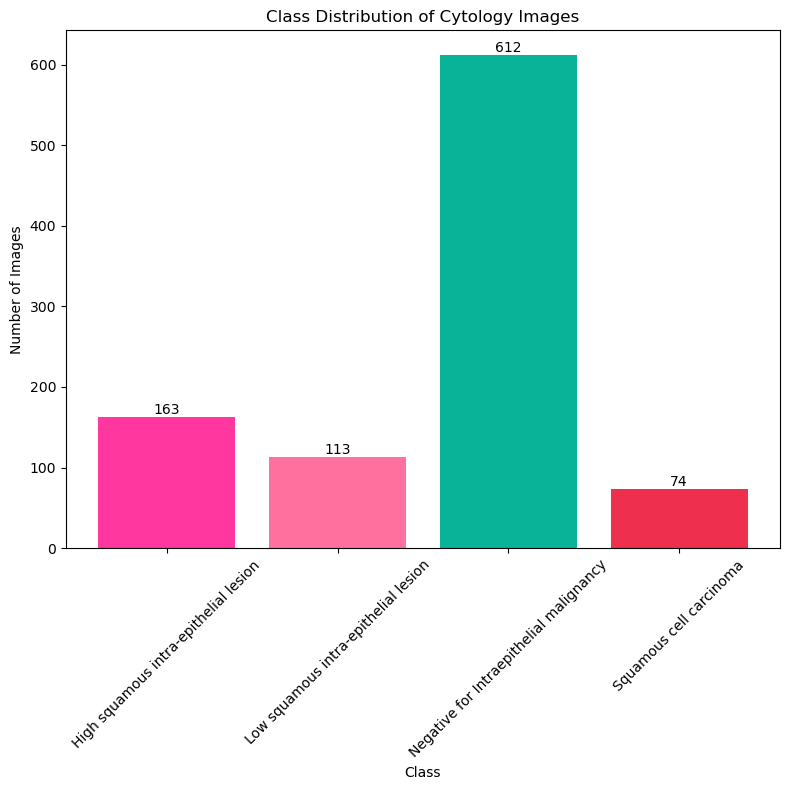

In [4]:
plt.figure(figsize=(8, 8))
class_counts = [labels.count(class_name) for class_name in classes]

# Plot the histogram with pastel colors
bars = plt.bar(classes, class_counts, color=['#FF379E', '#FF709E', '#08B397', '#EE304E'])
plt.title('Class Distribution of Cytology Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

# Add class counts over each bar
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [5]:
from PIL import Image

# Specify the path to your image
image_path = 'data/High squamous intra-epithelial lesion/HSIL_1 (1).jpg'  # Change this to any image path you want

# Open the image
img = Image.open(image_path)

# Get the resolution (width and height)
width, height = img.size

# Print the resolution
print(f"The resolution of the image is: {width}x{height}")


The resolution of the image is: 2048x1536


In [6]:
def extract_patches(image_path):
    """
    Extracts 256x256 patches from a 2048x1536 image and returns them as a list of images.
    
    Parameters:
    - image_path (str): Path to the input image (2048x1536 jpg image).
    
    Returns:
    - patches (list): List of PIL Image objects representing the extracted 256x256 patches.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Define the patch size and grid dimensions
    patch_size = 256
    grid_width = 8  # Number of patches across the width (2048 / 256 = 8)
    grid_height = 6  # Number of patches down the height (1536 / 256 = 6)
    
    # Get the base name of the image (to use for patch naming)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    patches = []  # List to store the patches
    
    # Loop over the grid and extract patches
    patch_count = 0
    for i in range(grid_height):
        for j in range(grid_width):
            # Define the left, upper, right, and lower coordinates for the patch
            left = j * patch_size
            upper = i * patch_size
            right = left + patch_size
            lower = upper + patch_size
            
            # Extract the patch
            patch = img.crop((left, upper, right, lower))
            patches.append(patch)  # Add the patch to the list
            
            # Optionally: You can keep track of the patch names if needed for later use
            patch_name = f"{base_name}_p_{patch_count + 1}.jpg"
            patch_count += 1
    
    # Return the list of extracted patches
    return patches

In [38]:
def save_patches_from_directory(data_dir, output_dir):
    """
    Iterates through the data directory, extracts patches from each image, and saves them in class subdirectories.
    
    Parameters:
    - data_dir (str): Path to the root directory containing subdirectories for each class.
    - output_dir (str): Path to the directory where the patches will be saved.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate over each class directory
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_dir):
            # Create a subdirectory for each class in the output folder
            class_output_dir = os.path.join(output_dir, class_name)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)
            
            # Iterate over all image files in the class directory
            for img_file in os.listdir(class_dir):
                if img_file.endswith(".jpg"):
                    img_path = os.path.join(class_dir, img_file)
                    
                    # Extract patches from the image
                    patches = extract_patches(img_path)
                    
                    # Save each patch
                    for idx, patch in enumerate(patches):
                        patch_name = f"{os.path.splitext(img_file)[0]}_p_{idx + 1}.jpg"
                        patch.save(os.path.join(class_output_dir, patch_name))
                    
                    # print(f"Processed {img_file} into {len(patches)} patches in class '{class_name}'")
                    
# Example usage:
data_dir = "data"  # Replace with the path to your data directory
output_dir = "./patches"  # Path to the folder where patches will be saved
save_patches_from_directory(data_dir, output_dir)


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTConfig
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np


In [79]:
from torch.nn import DataParallel as DP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Load the pretrained ViT model and adjust it for your task (e.g., 4 output classes)
model_name = "google/vit-base-patch16-224-in21k"  # You can use ViT-B32 or other variants
model = ViTForImageClassification.from_pretrained(model_name, num_labels=4, output_hidden_states=True)

# Conditionally use DataParallel if more than 1 GPU is available
if torch.cuda.device_count() > 1:
    print("Using multiple GPUs with DataParallel.")
    model = DP(model)  # Wrap the model with DataParallel
else:
    print("Using single GPU or CPU.")

model = model.to(device)  # Move model to the appropriate device (GPU/CPU)

Using device: cuda


/home/arjun.j/miniconda3/envs/cervic-ai/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using multiple GPUs with DataParallel.


In [80]:
from torchvision import transforms
# Function to calculate mean and std for the dataset
def calculate_mean_std(image_paths, transform=None):
    means = []
    stds = []
    
    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        
        if transform:
            img = transform(img)  # Apply transformations (e.g., ToTensor)
        
        # Convert image to tensor and calculate the mean and std for each channel (RGB)
        means.append(img.mean(dim=(1, 2)))  # Mean for R, G, B
        stds.append(img.std(dim=(1, 2)))    # Std for R, G, B
    
    # Convert lists to numpy arrays
    means = torch.stack(means).numpy()
    stds = torch.stack(stds).numpy()
    
    # Calculate mean and std for all images in the dataset
    dataset_mean = means.mean(axis=0)
    dataset_std = stds.mean(axis=0)
    
    return dataset_mean, dataset_std


In [81]:
# Function to get 10 images from each class subdirectory
def get_image_paths(data_dir, num_images_per_class=80):
    image_paths = []
    
    # Iterate over each class subdirectory
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_dir):
            # Get all .jpg image paths in the class directory
            img_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
            
            # Randomly sample 10 images (or all if fewer than 10)
            sampled_files = random.sample(img_files, min(num_images_per_class, len(img_files)))
            image_paths.extend([os.path.join(class_dir, f) for f in sampled_files])
    
    return image_paths


# Main execution
data_dir = 'data'  # Your data directory
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
])

# Get image paths from the dataset
image_paths = get_image_paths(data_dir, num_images_per_class=10)

# Calculate mean and std
mean, std = calculate_mean_std(image_paths, transform)

# Print the results
print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")

Dataset Mean: [0.56725144 0.6040802  0.66386193]
Dataset Std: [0.12189708 0.13033037 0.08450681]


In [82]:
class PatchDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Dataset class that automatically assigns integer labels based on directory names.
        
        Parameters:
        - data_dir (str): Path to the root directory where subdirectories represent classes.
        - transform (callable, optional): Optional transformation to be applied on a sample.
        """
        self.image_paths = []  # List of image paths
        self.labels = []       # Corresponding labels

        # Label mapping based on directory names
        self.class_to_idx = {
            "Negative for Intraepithelial malignancy": 0,  # NILM
            "Low squamous intra-epithelial lesion": 1,     # LSIL
            "High squamous intra-epithelial lesion": 2,    # HSIL
            "Squamous cell carcinoma": 3                   # SCC
        }

        # Loop through each class subdirectory and collect image paths and labels
        for class_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                # If the class name is valid (exists in the class_to_idx mapping), process it
                if class_name in self.class_to_idx:
                    for img_file in os.listdir(class_dir):
                        if img_file.endswith('.jpg'):  # Assuming .jpg images
                            img_path = os.path.join(class_dir, img_file)
                            self.image_paths.append(img_path)
                            self.labels.append(self.class_to_idx[class_name])  # Get label from class directory

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)  # Apply transformations (e.g., resize, normalize)

        return img, label

# Define the transformations (resize to 256x256, convert to tensor, and normalize with custom values)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5674744, 0.5998224, 0.6578784],  # dataset mean
                         std=[0.11348647, 0.12352826, 0.07994349])  # dataset std
])


In [83]:
data_dir = 'patches'
dataset = PatchDataset(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [84]:
# Reinforcement Learning Agent
class RLAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RLAgent, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, output_dim)  # Output the attention weights (for each patch)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        return self.fc2(x)  # Output the attention weights for each patch

    def select_patches(self, features):
        """
        Given the extracted features, the RL agent selects the most informative patches
        based on the learned attention weights.
        """
        logits = self(features)  # Get the attention weights (logits)
        attention_weights = F.softmax(logits, dim=-1)  # Normalize to get probabilities (weights)
        return attention_weights


# Reward function: guides the agent on what actions lead to better performance
class RewardFunction:
    def __init__(self):
        pass

    def compute(self, predicted_class, true_class, selected_patches, patch_importance):
        """
        Reward function:
        - Positive reward if the prediction is correct and selected patches are relevant.
        - Negative reward if the prediction is wrong or irrelevant regions are selected.
        """
        if predicted_class == true_class:
            reward = 1  # Positive reward for correct classification
        else:
            reward = -1  # Negative reward for incorrect classification
        
        # Encourage selection of relevant patches (e.g., based on patch importance or saliency)
        relevant_patch_score = torch.sum(selected_patches * patch_importance)  # Score based on saliency/importance
        reward += relevant_patch_score.item()  # Adjust reward based on relevance of selected patches

        return reward

In [89]:
agent = RLAgent(input_dim=768, output_dim=48).to(device)  # Example, adjust as needed
optimizer = optim.AdamW(list(model.parameters()) + list(agent.parameters()), lr=3e-5)
reward_function = RewardFunction()

# Training Loop with RL Integration
def train_with_rl(model, dataloader, agent, optimizer, reward_function, device):
    model.train()
    agent.train()

    for img_batch, label_batch in dataloader:
        # Move data to GPU
        img_batch = img_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()

        # Forward pass through ViT model
        outputs = model(img_batch)
        logits = outputs.logits  # Logits from the model

        # Get the last hidden state (features from the last layer of the transformer)
        features = outputs.hidden_states[-1]  # Last hidden state (last transformer layer)

        # RL agent selects patches based on features
        selected_patches = agent.select_patches(features)

        # Compute the predicted class (max probability)
        predicted_class = torch.argmax(logits, dim=-1)

        # Compute reward based on the predicted class and selected patches
        reward = reward_function.compute(predicted_class, label_batch, selected_patches)

        # Backpropagate the reward and update the model and RL agent
        reward.backward()
        optimizer.step()

        print(f"Reward: {reward.item()}")

In [90]:
train_with_rl(model, dataloader, agent, optimizer, reward_function, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [91]:
torch.cuda.empty_cache()